## Input File insertion

In [95]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 041_Assignment5_Sushar_Hembram_input_ucs.json to 041_Assignment5_Sushar_Hembram_input_ucs.json
Saving 041_Assignment5_Sushar_Hembram_input_ils.json to 041_Assignment5_Sushar_Hembram_input_ils.json
Saving 041_Assignment5_Sushar_Hembram_input_ids.json to 041_Assignment5_Sushar_Hembram_input_ids.json
Saving 041_Assignment5_Sushar_Hembram_input_dls.json to 041_Assignment5_Sushar_Hembram_input_dls.json
Saving 041_Assignment5_Sushar_Hembram_input_dfs.json to 041_Assignment5_Sushar_Hembram_input_dfs.json
Saving 041_Assignment5_Sushar_Hembram_input_bfs.json to 041_Assignment5_Sushar_Hembram_input_bfs.json
User uploaded file "041_Assignment5_Sushar_Hembram_input_ucs.json" with length 157 bytes
User uploaded file "041_Assignment5_Sushar_Hembram_input_ils.json" with length 160 bytes
User uploaded file "041_Assignment5_Sushar_Hembram_input_ids.json" with length 157 bytes
User uploaded file "041_Assignment5_Sushar_Hembram_input_dls.json" with length 159 bytes
User uploaded file "041_Assignme

## Missionaries and Carnivals Problem (in BFS, DLS, DFS, IDS, ILS, UCS)

In [96]:
import time
import resource
import json
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

In [97]:
def get_memory_kb():
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

In [98]:
def is_valid(state):
    f, w, g, c, b = state
    if g == w and f != g: return False
    if g == c and f != g: return False
    return True

def next_states(state):
    f, w, g, c, b = state
    nb = 'R' if b == 'L' else 'L'
    moves = []
    # Farmer alone
    ns = (nb if f == b else f, w, g, c, nb)
    if is_valid(ns): moves.append((ns, "F alone"))
    # Farmer + Wolf
    if f == w == b:
        ns = (nb, nb, g, c, nb)
        if is_valid(ns): moves.append((ns, "F+W"))
    # Farmer + Goat
    if f == g == b:
        ns = (nb, w, nb, c, nb)
        if is_valid(ns): moves.append((ns, "F+G"))
    # Farmer + Cabbage
    if f == c == b:
        ns = (nb, w, g, nb, nb)
        if is_valid(ns): moves.append((ns, "F+C"))
    return moves

In [99]:
def state_str(s):
    n = ['F', 'W', 'G', 'C', 'B']
    return ', '.join(f"{x}:{y}" for x, y in zip(n, s))

In [100]:
def log_step(logfile, msg):
    with open(logfile, 'a') as f:
        f.write(msg + '\n')

### BFS (Breadth First Search)

In [101]:
def bfs(start, goal, logfile):
    queue = deque()
    queue.append((start, [start], []))
    visited = set()
    step = 0
    while queue:
        s, path, actions = queue.popleft()
        log_step(logfile, f"Step {step}: {state_str(s)}")
        log_step(logfile, f"Frontier: {[state_str(x[0]) for x in queue]}")
        if s == goal:
            return path, actions
        visited.add(s)
        for ns, a in next_states(s):
            if ns not in visited:
                queue.append((ns, path + [ns], actions + [a]))
        step += 1
    return None, None

### DFS (Depth First Search)

Exploring as far as possible along each branch before backtracking using a stack (LIFO). If depth_limit is set, the program performs a Depth-Limited Search (DLS).
    

In [102]:
def dfs(start, goal, logfile):
    stack = [(start, [start], [])]
    visited = set()
    step = 0
    while stack:
        s, path, actions = stack.pop()
        log_step(logfile, f"Step {step}: {state_str(s)}")
        log_step(logfile, f"Stack: {[state_str(x[0]) for x in stack]}")
        if s == goal:
            return path, actions
        visited.add(s)
        for ns, a in next_states(s):
            if ns not in visited:
                stack.append((ns, path + [ns], actions + [a]))
        step += 1
    return None, None

### DLS (Depth Limited Search)

In [103]:
def dls(start, goal, logfile, limit):
    stack = [(start, [start], [], 0)]
    visited = set()
    step = 0
    while stack:
        s, path, actions, depth = stack.pop()
        log_step(logfile, f"Step {step}: {state_str(s)} (depth {depth})")
        if s == goal:
            return path, actions
        if depth >= limit:
            continue
        visited.add(s)
        for ns, a in next_states(s):
            if ns not in visited:
                stack.append((ns, path + [ns], actions + [a], depth + 1))
        step += 1
    return None, None

### IDS (Iterative Deepening Search)

Repeatedly applying DLS with increasing depth limits.
    

In [104]:
def ids(start, goal, logfile, max_depth):
    for limit in range(1, max_depth+1):
        log_step(logfile, f"IDS: Trying depth {limit}")
        result = dls(start, goal, logfile, limit)
        if result[0]:
            return result
    return None, None

### UCS (Uniform Cost Search)

Expanding the least-codenode using a priority queue.

In [105]:
def ucs(start, goal, logfile, step_cost=1):
    import heapq
    heap = []
    heapq.heappush(heap, (0, start, [start], []))
    visited = set()
    step = 0
    while heap:
        cost, s, path, actions = heapq.heappop(heap)
        log_step(logfile, f"Step {step}: {state_str(s)} (cost {cost})")
        log_step(logfile, f"Heap: {[state_str(x[1]) for x in heap]}")
        if s == goal:
            return path, actions
        visited.add(s)
        for ns, a in next_states(s):
            if ns not in visited:
                heapq.heappush(heap, (cost + step_cost, ns, path + [ns], actions + [a]))
        step += 1
    return None, None

### ILS (Iterative Local Search)

Performing multiple DFS runs with randomization and restarting.

In [106]:
def ils(start, goal, logfile, max_restarts=5):
    import random
    best_path = None
    best_actions = None
    for restart in range(max_restarts):
        log_step(logfile, f"ILS: Restart {restart}")
        stack = [(start, [start], [], 0)]
        visited = set()
        while stack:
            s, path, actions, depth = stack.pop()
            log_step(logfile, f"ILS Step: {state_str(s)} (d {depth})")
            if s == goal:
                if not best_path or len(path) < len(best_path):
                    best_path = path
                    best_actions = actions
                break
            visited.add(s)
            nxt = next_states(s)
            random.shuffle(nxt)
            for ns, a in nxt:
                if ns not in visited:
                    stack.append((ns, path + [ns], actions + [a], depth + 1))
    return best_path, best_actions

## Main Function

In [107]:
def run_and_log(algo_name, algo_func, params, logfile, **kwargs):
    open(logfile, 'w').close()  # Clear log
    start = tuple(params["start"])
    goal = tuple(params["goal"])
    mem_before = get_memory_kb()
    t0 = time.time()
    if kwargs:
        path, actions = algo_func(start, goal, logfile, **kwargs)
    else:
        path, actions = algo_func(start, goal, logfile)
    t1 = time.time()
    mem_after = get_memory_kb()
    if path:
        log_step(logfile, f"Solution in {len(path)-1} steps:")
        for i, (s, a) in enumerate(zip(path[1:], actions)):
            log_step(logfile, f"Step {i+1}: {a} -> {state_str(s)}")
    else:
        log_step(logfile, "No solution found.")
    log_step(logfile, f"Time: {t1-t0:.4f}s")
    log_step(logfile, f"Memory used: {mem_after - mem_before} KB")
    return {
        "algorithm": algo_name,
        "param": kwargs.get("limit", kwargs.get("max_depth", None)),
        "time": t1-t0,
        "memory": mem_after - mem_before
    }

In [112]:
results = []

# BFS
with open("041_Assignment5_Sushar_Hembram_input_bfs.json") as f:
    params = json.load(f)
results.append(run_and_log("BFS", bfs, params, params["logfile"]))

# DFS
with open("041_Assignment5_Sushar_Hembram_input_dfs.json") as f:
    params = json.load(f)
results.append(run_and_log("DFS", dfs, params, params["logfile"]))

# DLS
with open("041_Assignment5_Sushar_Hembram_input_dls.json") as f:
    params = json.load(f)
for d in [2, 3, 4]:
    results.append(run_and_log("DLS", dls, params, f"041_Assignment5_Sushar_Hembram_output_dls_{d}.txt", limit=d))

# IDS
with open("041_Assignment5_Sushar_Hembram_input_ids.json") as f:
    params = json.load(f)
for d in [2, 3, 4]:
    results.append(run_and_log("IDS", ids, params, f"041_Assignment5_Sushar_Hembram_output_ids_{d}.txt", max_depth=d))

# UCS
with open("041_Assignment5_Sushar_Hembram_input_ucs.json") as f:
    params = json.load(f)
step_cost = params.get("step_cost", 1)
results.append(run_and_log("UCS", ucs, params, params["logfile"], step_cost=step_cost))

# ILS
with open("041_Assignment5_Sushar_Hembram_input_ils.json") as f:
    params = json.load(f)
max_restarts = params.get("max_restarts", 5)
results.append(run_and_log("ILS", ils, params, params["logfile"], max_restarts=max_restarts))

  algorithm  param      time  memory
0       BFS    NaN  0.000916       0
1       DFS    NaN  0.000710       0
2       DLS    2.0  0.000171       0
3       DLS    3.0  0.000211       0
4       DLS    4.0  0.000240       0
5       IDS    2.0  0.000250       0
6       IDS    3.0  0.000482       0
7       IDS    4.0  0.000674       0
8       UCS    NaN  0.000870       0
9       ILS    NaN  0.001841       0


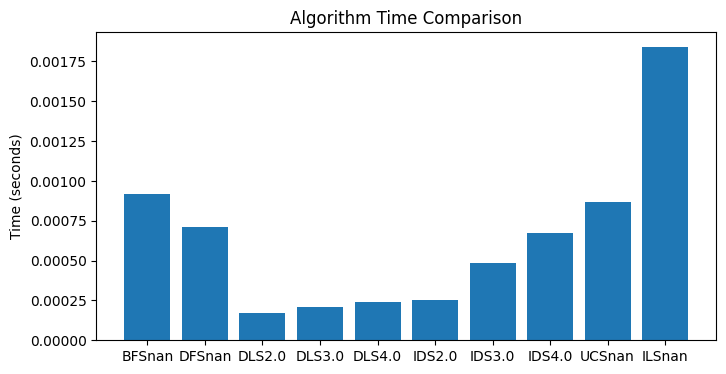

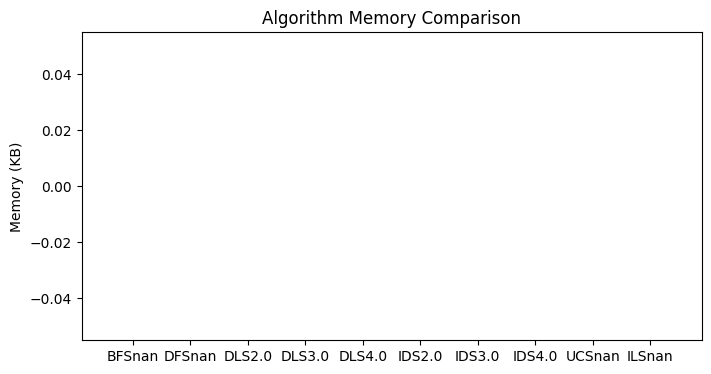

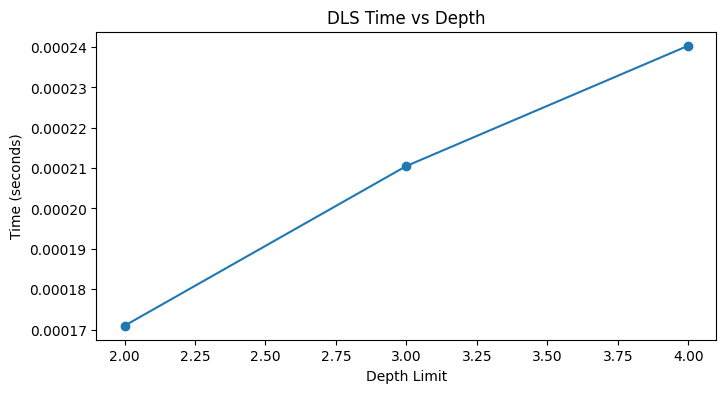

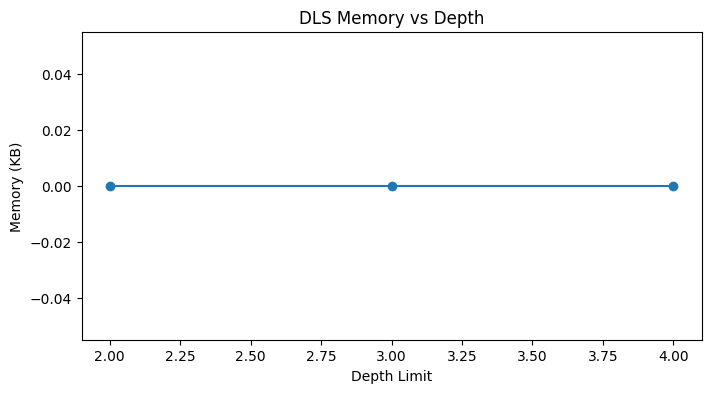

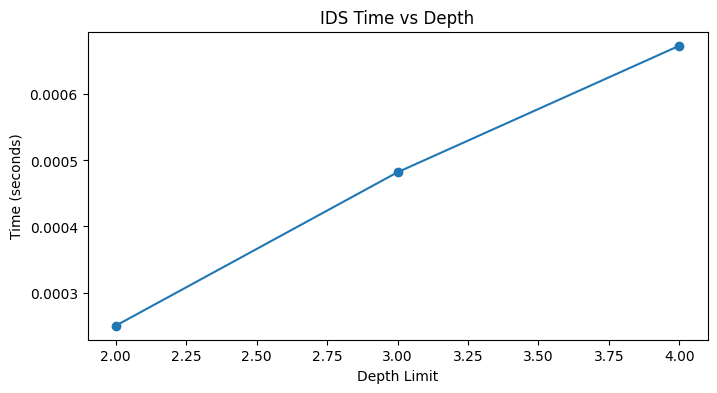

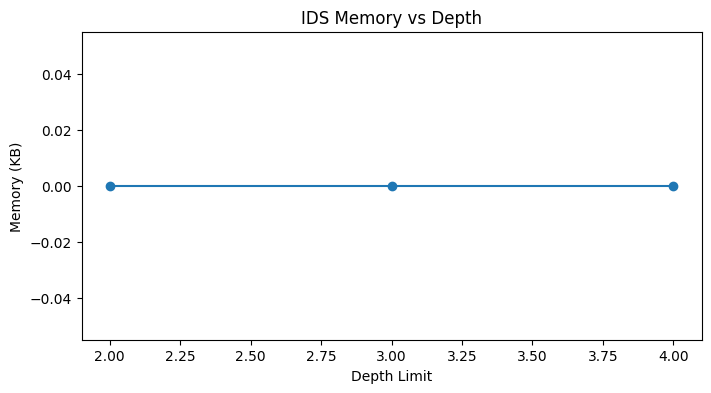

In [113]:
df = pd.DataFrame(results)
print(df)
df.to_csv("041_Sushar_Hembram_Assignment5_results_summary.csv", index=False)

# Bar plots for all algorithms
# Saving each plotting into png files
plt.figure(figsize=(8,4))
plt.bar(df['algorithm'] + df['param'].astype(str), df['time'])
plt.ylabel("Time (seconds)")
plt.title("Algorithm Time Comparison")
plt.savefig("041_Assignment5_Sushar_Hembram_algorithm_time_comparison.png")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(df['algorithm'] + df['param'].astype(str), df['memory'])
plt.ylabel("Memory (KB)")
plt.title("Algorithm Memory Comparison")
plt.savefig("041_Assignment5_Sushar_Hembram_algorithm_memory_comparison.png")
plt.show()

# For DLS/IDS parameter plots
for algo in ['DLS', 'IDS']:
    sub = df[df['algorithm'] == algo]
    if not sub.empty:
        plt.figure(figsize=(8,4))
        plt.plot(sub['param'], sub['time'], marker='o')
        plt.xlabel("Depth Limit")
        plt.ylabel("Time (seconds)")
        plt.title(f"{algo} Time vs Depth")
        plt.savefig(f"041_Assignment5_Sushar_Hembram_{algo.lower()}_time_vs_depth.png")
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(sub['param'], sub['memory'], marker='o')
        plt.xlabel("Depth Limit")
        plt.ylabel("Memory (KB)")
        plt.title(f"{algo} Memory vs Depth")
        plt.savefig(f"041_Assignment5_Sushar_Hembram_{algo.lower()}_memory_vs_depth.png")
        plt.show()

In [117]:
from google.colab import files

# Commented out previous download calls.
# files.download('041_Sushar_Hembram_Assignment5_results_summary.csv')
# files.download('041_Assignment5_Sushar_Hembram_algorithm_time_comparison.png')
# files.download('041_Assignment5_Sushar_Hembram_algorithm_memory_comparison.png')
# files.download('041_Assignment5_Sushar_Hembram_dls_time_vs_depth.png')
# files.download('041_Assignment5_Sushar_Hembram_dls_memory_vs_depth.png')
# files.download('041_Assignment5_Sushar_Hembram_ids_time_vs_depth.png')
# files.download('041_Assignment5_Sushar_Hembram_ids_memory_vs_depth.png')
# files.download('041_Sushar_Hembram_Assignment5_output_bfs.txt')
# files.download('041_Sushar_Hembram_Assignment5_output_dfs.txt')
# files.download('041_Assignment5_Sushar_Hembram_output_dls_2.txt')
files.download('041_Assignment5_Sushar_Hembram_output_dls_3.txt')
files.download('041_Assignment5_Sushar_Hembram_output_dls_4.txt')
files.download('041_Assignment5_Sushar_Hembram_output_ids_2.txt')
files.download('041_Assignment5_Sushar_Hembram_output_ids_3.txt')
files.download('041_Assignment5_Sushar_Hembram_output_ids_4.txt')
files.download('041_Sushar_Hembram_Assignment5_output_ucs.txt')
files.download('041_Sushar_Hembram_Assignment5_output_ils.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>